<a href="https://colab.research.google.com/github/CeciSC/LSTMEquityIndexPrediction/blob/main/sp500_RNN_monthly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add S&P 500 and HS300

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print(tf.__version__)


2.3.0


In [ ]:
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import time

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sp500_m.csv to sp500_m.csv


# New Section

In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.StringIO(uploaded['sp500_m.csv'].decode('utf-8')))
df

,Date,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,2005-05-31,1191.329956,1191.500000,1219.589966,1188.300049,4.033404e+10,1191.500000,1172.920000,1210.410000,1182.762,1164.857,1137.1110,0.738779,2.287234,36.902700,1205.158581,1142.078342,85.362496,50.841736,3.245093,10.234286,-2.36,37.45,22.335056,40.458262,1.732236,0.997367,61.371429,60.833048,75.000000,3571873693,-0.000143,-0.000143,0.096833,-0.003441,0.008672,0.049167,0.047681
1,2005-06-30,1234.180054,1191.329956,1245.150024,1183.550049,3.746467e+10,1191.329956,1191.500000,1172.920000,1184.774,1173.566,1144.1420,0.553354,1.513677,36.855092,1216.630273,1185.487419,26.692518,85.362496,-1.044929,9.025000,-22.55,-12.58,27.195508,40.641136,-0.426619,0.284519,61.293204,60.798954,41.666667,3312885958,0.035968,0.035968,0.821916,0.001701,0.006183,0.041916,0.078695
2,2005-07-29,1220.329956,1234.180054,1245.859985,1201.069946,4.203009e+10,1234.180054,1191.329956,1191.500000,1190.890,1185.526,1152.9410,3.635096,4.104001,39.816024,1249.493946,1182.850670,72.322432,26.692518,0.890222,8.697857,7.14,10.89,7.079246,10.064220,1.505369,1.229264,72.063579,66.033466,66.666667,3551287437,-0.011222,-0.011222,0.430007,0.005162,0.007690,0.040859,0.058450
3,2005-08-31,1228.810059,1220.329956,1243.130005,1205.349976,4.477751e+10,1220.329956,1234.180054,1191.329956,1198.838,1194.539,1158.3615,1.792736,2.159076,40.577256,1248.468674,1203.293634,37.222523,72.322432,-1.097360,10.375000,2.76,-13.54,21.575256,23.270440,-1.199444,-0.856001,65.043709,63.064201,58.333333,3298480177,0.006949,0.006949,0.620965,0.006674,0.004701,0.039809,0.060817
4,2005-09-30,1207.010010,1228.810059,1233.339966,1168.199951,4.979379e+10,1228.810059,1220.329956,1234.180054,1213.230,1200.038,1163.2455,1.284175,2.397591,41.387711,1243.548118,1202.815729,54.282552,37.222523,0.134457,10.241429,14.19,1.65,15.540972,17.104735,-0.261361,-0.105049,67.378482,64.141200,75.000000,3571033681,-0.017741,-0.017741,0.595794,0.012005,0.004216,0.047367,0.037623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2020-07-31,3500.310059,3288.260010,3514.770020,3284.530029,8.440230e+10,3271.120117,3100.290039,3044.310059,2982.548,3050.180,2942.7435,9.675351,7.243507,117.826149,3323.197776,3047.106839,68.933903,47.279535,1.381037,40.662143,35.46,44.56,10.185909,0.815160,1.739635,1.769585,65.515365,61.628608,66.666667,11133143027,0.070065,0.064487,0.937196,0.021712,0.008758,0.022402,0.189472
183,2020-08-31,3363.000000,3507.439941,3588.110107,3209.449951,9.208412e+10,3500.310059,3271.120117,3100.290039,3165.692,3096.455,2992.4165,10.570138,13.042495,147.463492,3521.738144,3205.918779,93.667501,68.933903,3.761157,27.961429,103.15,126.88,1.093045,1.354846,3.182929,1.902125,73.310168,66.783129,83.333333,11245784083,-0.039228,-0.041181,0.405509,0.061405,0.016880,0.075762,0.123841
184,2020-09-30,3269.959961,3385.870117,3549.850098,3233.939941,8.973760e+10,3363.000000,3500.310059,3271.120117,3255.806,3118.657,3025.3615,3.292395,7.834879,158.049634,3561.786851,3214.449303,62.324836,93.667501,-0.607057,61.167143,47.43,-20.54,16.122471,27.403314,-2.504374,-1.919132,63.062228,61.393051,50.000000,11091627946,-0.027666,-0.034233,0.114020,0.028466,0.011009,0.088019,0.080849
185,2020-10-30,3557.540039,3296.199951,3645.989990,3279.739990,7.570161e+10,3269.959961,3363.000000,3500.310059,3300.936,3122.575,3049.6350,-0.938401,4.719983,157.120489,3550.492392,3261.812224,17.475692,62.324836,-6.269151,57.162143,-183.53,-218.71,22.786034,51.112539,-1.635029,-0.096604,56.625926,57.936547,50.000000,10963922377,0.087946,0.079285,0.758498,0.013861,0.008023,0.091088,0.166546


In [ ]:
df.dtypes

Date                              object
Close                            float64
Open                             float64
High                             float64
Low                              float64
Volume                           float64
x(t-1)                           float64
x(t-2)                           float64
x(t-3)                           float64
MA5                              float64
MA10                             float64
MA20                             float64
BIAS5                            float64
BIAS10                           float64
DIFF                             float64
BU                               float64
BL                               float64
KDJ                              float64
KDJ(t-1)                         float64
ROC                              float64
TR（14）                           float64
MTM6                             float64
MTM12                            float64
WR%10                            float64
WR%5            

In [ ]:
df[['OBV']] = df[['OBV']].astype('float')

df_feature = df
df_feature = df_feature.drop(['Date'], axis=1)
df_feature.head()

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1191.329956,1191.500000,1219.589966,1188.300049,4.033404e+10,1191.500000,1172.920000,1210.410000,1182.762,1164.857,1137.1110,0.738779,2.287234,36.902700,1205.158581,1142.078342,85.362496,50.841736,3.245093,10.234286,-2.36,37.45,22.335056,40.458262,1.732236,0.997367,61.371429,60.833048,75.000000,3.571874e+09,-0.000143,-0.000143,0.096833,-0.003441,0.008672,0.049167,0.047681
1,1234.180054,1191.329956,1245.150024,1183.550049,3.746467e+10,1191.329956,1191.500000,1172.920000,1184.774,1173.566,1144.1420,0.553354,1.513677,36.855092,1216.630273,1185.487419,26.692518,85.362496,-1.044929,9.025000,-22.55,-12.58,27.195508,40.641136,-0.426619,0.284519,61.293204,60.798954,41.666667,3.312886e+09,0.035968,0.035968,0.821916,0.001701,0.006183,0.041916,0.078695
2,1220.329956,1234.180054,1245.859985,1201.069946,4.203009e+10,1234.180054,1191.329956,1191.500000,1190.890,1185.526,1152.9410,3.635096,4.104001,39.816024,1249.493946,1182.850670,72.322432,26.692518,0.890222,8.697857,7.14,10.89,7.079246,10.064220,1.505369,1.229264,72.063579,66.033466,66.666667,3.551287e+09,-0.011222,-0.011222,0.430007,0.005162,0.007690,0.040859,0.058450
3,1228.810059,1220.329956,1243.130005,1205.349976,4.477751e+10,1220.329956,1234.180054,1191.329956,1198.838,1194.539,1158.3615,1.792736,2.159076,40.577256,1248.468674,1203.293634,37.222523,72.322432,-1.097360,10.375000,2.76,-13.54,21.575256,23.270440,-1.199444,-0.856001,65.043709,63.064201,58.333333,3.298480e+09,0.006949,0.006949,0.620965,0.006674,0.004701,0.039809,0.060817
4,1207.010010,1228.810059,1233.339966,1168.199951,4.979379e+10,1228.810059,1220.329956,1234.180054,1213.230,1200.038,1163.2455,1.284175,2.397591,41.387711,1243.548118,1202.815729,54.282552,37.222523,0.134457,10.241429,14.19,1.65,15.540972,17.104735,-0.261361,-0.105049,67.378482,64.141200,75.000000,3.571034e+09,-0.017741,-0.017741,0.595794,0.012005,0.004216,0.047367,0.037623


In [ ]:
df_feature.shape

(187, 37)

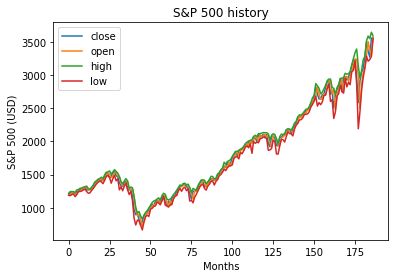

In [ ]:
### EDA
plt.figure()
plt.plot(df_feature[["Close"]])
plt.plot(df_feature[["Open"]])
plt.plot(df_feature[["High"]])
plt.plot(df_feature[["Low"]])
plt.title('S&P 500 history')
plt.ylabel('S&P 500 (USD)')
plt.xlabel('Months')
plt.legend(['close', 'open','high','low'], loc='upper left')
plt.show()

In [ ]:
df_feature

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1191.329956,1191.500000,1219.589966,1188.300049,4.033404e+10,1191.500000,1172.920000,1210.410000,1182.762,1164.857,1137.1110,0.738779,2.287234,36.902700,1205.158581,1142.078342,85.362496,50.841736,3.245093,10.234286,-2.36,37.45,22.335056,40.458262,1.732236,0.997367,61.371429,60.833048,75.000000,3.571874e+09,-0.000143,-0.000143,0.096833,-0.003441,0.008672,0.049167,0.047681
1,1234.180054,1191.329956,1245.150024,1183.550049,3.746467e+10,1191.329956,1191.500000,1172.920000,1184.774,1173.566,1144.1420,0.553354,1.513677,36.855092,1216.630273,1185.487419,26.692518,85.362496,-1.044929,9.025000,-22.55,-12.58,27.195508,40.641136,-0.426619,0.284519,61.293204,60.798954,41.666667,3.312886e+09,0.035968,0.035968,0.821916,0.001701,0.006183,0.041916,0.078695
2,1220.329956,1234.180054,1245.859985,1201.069946,4.203009e+10,1234.180054,1191.329956,1191.500000,1190.890,1185.526,1152.9410,3.635096,4.104001,39.816024,1249.493946,1182.850670,72.322432,26.692518,0.890222,8.697857,7.14,10.89,7.079246,10.064220,1.505369,1.229264,72.063579,66.033466,66.666667,3.551287e+09,-0.011222,-0.011222,0.430007,0.005162,0.007690,0.040859,0.058450
3,1228.810059,1220.329956,1243.130005,1205.349976,4.477751e+10,1220.329956,1234.180054,1191.329956,1198.838,1194.539,1158.3615,1.792736,2.159076,40.577256,1248.468674,1203.293634,37.222523,72.322432,-1.097360,10.375000,2.76,-13.54,21.575256,23.270440,-1.199444,-0.856001,65.043709,63.064201,58.333333,3.298480e+09,0.006949,0.006949,0.620965,0.006674,0.004701,0.039809,0.060817
4,1207.010010,1228.810059,1233.339966,1168.199951,4.979379e+10,1228.810059,1220.329956,1234.180054,1213.230,1200.038,1163.2455,1.284175,2.397591,41.387711,1243.548118,1202.815729,54.282552,37.222523,0.134457,10.241429,14.19,1.65,15.540972,17.104735,-0.261361,-0.105049,67.378482,64.141200,75.000000,3.571034e+09,-0.017741,-0.017741,0.595794,0.012005,0.004216,0.047367,0.037623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,3500.310059,3288.260010,3514.770020,3284.530029,8.440230e+10,3271.120117,3100.290039,3044.310059,2982.548,3050.180,2942.7435,9.675351,7.243507,117.826149,3323.197776,3047.106839,68.933903,47.279535,1.381037,40.662143,35.46,44.56,10.185909,0.815160,1.739635,1.769585,65.515365,61.628608,66.666667,1.113314e+10,0.070065,0.064487,0.937196,0.021712,0.008758,0.022402,0.189472
183,3363.000000,3507.439941,3588.110107,3209.449951,9.208412e+10,3500.310059,3271.120117,3100.290039,3165.692,3096.455,2992.4165,10.570138,13.042495,147.463492,3521.738144,3205.918779,93.667501,68.933903,3.761157,27.961429,103.15,126.88,1.093045,1.354846,3.182929,1.902125,73.310168,66.783129,83.333333,1.124578e+10,-0.039228,-0.041181,0.405509,0.061405,0.016880,0.075762,0.123841
184,3269.959961,3385.870117,3549.850098,3233.939941,8.973760e+10,3363.000000,3500.310059,3271.120117,3255.806,3118.657,3025.3615,3.292395,7.834879,158.049634,3561.786851,3214.449303,62.324836,93.667501,-0.607057,61.167143,47.43,-20.54,16.122471,27.403314,-2.504374,-1.919132,63.062228,61.393051,50.000000,1.109163e+10,-0.027666,-0.034233,0.114020,0.028466,0.011009,0.088019,0.080849
185,3557.540039,3296.199951,3645.989990,3279.739990,7.570161e+10,3269.959961,3363.000000,3500.310059,3300.936,3122.575,3049.6350,-0.938401,4.719983,157.120489,3550.492392,3261.812224,17.475692,62.324836,-6.269151,57.162143,-183.53,-218.71,22.786034,51.112539,-1.635029,-0.096604,56.625926,57.936547,50.000000,1.096392e+10,0.087946,0.079285,0.758498,0.013861,0.008023,0.091088,0.166546


In [ ]:
def get_profit_class(data):
    '''
    classify the price movement direction
    '''
    data_diff = data.diff(-next_n)
    data_diff[data_diff > 0] = 0 # price goes down
    data_diff[data_diff < 0] = 1 # price goes up
    return data_diff

next_n = 1

place_data = get_profit_class(df_feature)
df_feature['signal'] = place_data['Close']
df_feature['signal']= df_feature['signal'].shift(next_n).fillna(method='ffill').shift(-next_n).to_frame().fillna(method='ffill')
df_feature

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t),signal
0,1191.329956,1191.500000,1219.589966,1188.300049,4.033404e+10,1191.500000,1172.920000,1210.410000,1182.762,1164.857,1137.1110,0.738779,2.287234,36.902700,1205.158581,1142.078342,85.362496,50.841736,3.245093,10.234286,-2.36,37.45,22.335056,40.458262,1.732236,0.997367,61.371429,60.833048,75.000000,3.571874e+09,-0.000143,-0.000143,0.096833,-0.003441,0.008672,0.049167,0.047681,1.0
1,1234.180054,1191.329956,1245.150024,1183.550049,3.746467e+10,1191.329956,1191.500000,1172.920000,1184.774,1173.566,1144.1420,0.553354,1.513677,36.855092,1216.630273,1185.487419,26.692518,85.362496,-1.044929,9.025000,-22.55,-12.58,27.195508,40.641136,-0.426619,0.284519,61.293204,60.798954,41.666667,3.312886e+09,0.035968,0.035968,0.821916,0.001701,0.006183,0.041916,0.078695,0.0
2,1220.329956,1234.180054,1245.859985,1201.069946,4.203009e+10,1234.180054,1191.329956,1191.500000,1190.890,1185.526,1152.9410,3.635096,4.104001,39.816024,1249.493946,1182.850670,72.322432,26.692518,0.890222,8.697857,7.14,10.89,7.079246,10.064220,1.505369,1.229264,72.063579,66.033466,66.666667,3.551287e+09,-0.011222,-0.011222,0.430007,0.005162,0.007690,0.040859,0.058450,1.0
3,1228.810059,1220.329956,1243.130005,1205.349976,4.477751e+10,1220.329956,1234.180054,1191.329956,1198.838,1194.539,1158.3615,1.792736,2.159076,40.577256,1248.468674,1203.293634,37.222523,72.322432,-1.097360,10.375000,2.76,-13.54,21.575256,23.270440,-1.199444,-0.856001,65.043709,63.064201,58.333333,3.298480e+09,0.006949,0.006949,0.620965,0.006674,0.004701,0.039809,0.060817,0.0
4,1207.010010,1228.810059,1233.339966,1168.199951,4.979379e+10,1228.810059,1220.329956,1234.180054,1213.230,1200.038,1163.2455,1.284175,2.397591,41.387711,1243.548118,1202.815729,54.282552,37.222523,0.134457,10.241429,14.19,1.65,15.540972,17.104735,-0.261361,-0.105049,67.378482,64.141200,75.000000,3.571034e+09,-0.017741,-0.017741,0.595794,0.012005,0.004216,0.047367,0.037623,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,3500.310059,3288.260010,3514.770020,3284.530029,8.440230e+10,3271.120117,3100.290039,3044.310059,2982.548,3050.180,2942.7435,9.675351,7.243507,117.826149,3323.197776,3047.106839,68.933903,47.279535,1.381037,40.662143,35.46,44.56,10.185909,0.815160,1.739635,1.769585,65.515365,61.628608,66.666667,1.113314e+10,0.070065,0.064487,0.937196,0.021712,0.008758,0.022402,0.189472,0.0
183,3363.000000,3507.439941,3588.110107,3209.449951,9.208412e+10,3500.310059,3271.120117,3100.290039,3165.692,3096.455,2992.4165,10.570138,13.042495,147.463492,3521.738144,3205.918779,93.667501,68.933903,3.761157,27.961429,103.15,126.88,1.093045,1.354846,3.182929,1.902125,73.310168,66.783129,83.333333,1.124578e+10,-0.039228,-0.041181,0.405509,0.061405,0.016880,0.075762,0.123841,0.0
184,3269.959961,3385.870117,3549.850098,3233.939941,8.973760e+10,3363.000000,3500.310059,3271.120117,3255.806,3118.657,3025.3615,3.292395,7.834879,158.049634,3561.786851,3214.449303,62.324836,93.667501,-0.607057,61.167143,47.43,-20.54,16.122471,27.403314,-2.504374,-1.919132,63.062228,61.393051,50.000000,1.109163e+10,-0.027666,-0.034233,0.114020,0.028466,0.011009,0.088019,0.080849,1.0
185,3557.540039,3296.199951,3645.989990,3279.739990,7.570161e+10,3269.959961,3363.000000,3500.310059,3300.936,3122.575,3049.6350,-0.938401,4.719983,157.120489,3550.492392,3261.812224,17.475692,62.324836,-6.269151,57.162143,-183.53,-218.71,22.786034,51.112539,-1.635029,-0.096604,56.625926,57.936547,50.000000,1.096392e+10,0.087946,0.079285,0.758498,0.013861,0.008023,0.091088,0.166546,1.0


In [ ]:
data_train = df_feature.iloc[:150, :]
data_test = df_feature.iloc[150:, :]
print(data_train.shape, data_test.shape)

(150, 38) (37, 38)


In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(data_train)

# apply transformation to training data
train = scaler.transform(data_train)

# apply same transformation to test data
test = scaler.transform(data_test)

In [ ]:
test

array([[1.04799028, 1.03338843, 1.02040267, ..., 0.91882997, 0.91506384,
        1.        ],
       [1.12919041, 1.05422845, 1.11789503, ..., 0.92591895, 0.99147591,
        0.        ],
       [1.06973374, 1.1258281 , 1.09766762, ..., 0.95786282, 0.89088205,
        0.        ],
       ...,
       [1.37038511, 1.43301837, 1.48889175, ..., 0.87130872, 0.7977363 ,
        1.        ],
       [1.5258548 , 1.38464319, 1.54157807, ..., 0.87759645, 0.93109812,
        1.        ],
       [1.52599537, 1.53063709, 1.5107905 , ..., 0.92123935, 0.90995793,
        1.        ]])

In [ ]:
# y train/test: numeric labels, for regression 
y_train = np.array(df_feature.iloc[:150, 0])
y_test = np.array(df_feature.iloc[150:, 0])
print(y_train.shape, y_test.shape)

(150,) (37,)


In [ ]:
past_steps = 15
next_steps = 1

In [ ]:
X_train = train[:,:-1]
X_test = test[:,:-1]
y_train = train[:,-1]
y_test = test[:,-1]

In [ ]:
X_train = np.array([X_train[i : i + past_steps, :] for i in range(0, X_train.shape[0] - (next_steps+ past_steps),1)])
X_test = np.array([X_test[i : i + past_steps, :] for i in range(0, X_test.shape[0] - (next_steps+ past_steps),1)])

In [ ]:
X_train.shape

(134, 15, 37)

In [ ]:
y_train_regression = np.array([y_train[i + past_steps + next_steps] for i in range(0,train.shape[0] - (next_steps+ past_steps),1)])
y_test_regression = np.array([y_test[i + past_steps + next_steps] for i in range(0,test.shape[0] - (next_steps+ past_steps),1)])

In [ ]:
y_train_regression.shape

(134,)

In [ ]:
ret = df.iloc[167:, :]
ret = ret['return']
ret

167   -0.065778
168    0.068930
169    0.013128
170   -0.018092
171    0.017181
172    0.020432
173    0.034047
174    0.028590
175   -0.001628
176   -0.084110
177   -0.125119
178    0.126844
179    0.045282
180    0.018388
181    0.055101
182    0.070065
183   -0.039228
184   -0.027666
185    0.087946
186    0.000073
Name: return, dtype: float64

In [ ]:
    # create_single_layer_small_rnn_model
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(6))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    single_layer_small_rnn_preds = model.predict(X_test)
    table_1=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_1['reg_pred'] = single_layer_small_rnn_preds[:-1]

    # print(model)
    single_layer_small_rnn_preds[single_layer_small_rnn_preds >= 0.5] = 1
    single_layer_small_rnn_preds[single_layer_small_rnn_preds < 0.5] = 0

Train on 134 samples
Epoch 1/100
134/134 [==============================] - 0s 10us/sample - loss: 0.3143
Epoch 2/100
134/134 [==============================] - 0s 7us/sample - loss: 0.3003
Epoch 3/100
134/134 [==============================] - 0s 34us/sample - loss: 0.2898
Epoch 4/100
134/134 [==============================] - 0s 10us/sample - loss: 0.2831
Epoch 5/100
134/134 [==============================] - 0s 9us/sample - loss: 0.2785
Epoch 6/100
134/134 [==============================] - 0s 14us/sample - loss: 0.2751
Epoch 7/100
134/134 [==============================] - 0s 8us/sample - loss: 0.2723
Epoch 8/100
134/134 [==============================] - 0s 11us/sample - loss: 0.2700
Epoch 9/100
134/134 [==============================] - 0s 10us/sample - loss: 0.2679
Epoch 10/100
134/134 [==============================] - 0s 21us/sample - loss: 0.2661
Epoch 11/100
134/134 [==============================] - 0s 22us/sample - loss: 0.2645
Epoch 12/100
134/134 [=======================

In [ ]:
single_layer_small_rnn_preds.shape

(21, 1)

In [ ]:
table_1['y_test'] = y_test_regression[:-1]
table_1['class_pred'] = single_layer_small_rnn_preds[:-1]
table_1.to_csv('single-layer-small.csv')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print('accuracy of single layer small rnn:', accuracy_score(y_test_regression, single_layer_small_rnn_preds))
print('recall score of single layer small rnn:', recall_score(y_test_regression, single_layer_small_rnn_preds))

accuracy of single layer small rnn: 0.6190476190476191
recall score of single layer small rnn: 0.8571428571428571


In [ ]:
    # create_single_layer_rnn_model
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    single_layer_rnn_preds = model.predict(X_test)
    print(model)
    table_2=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_2['reg_pred'] = single_layer_rnn_preds[:-1]

    single_layer_rnn_preds[single_layer_rnn_preds >= 0.5] = 1
    single_layer_rnn_preds[single_layer_rnn_preds < 0.5] = 0
print('accuracy of single layer rnn:', accuracy_score(y_test_regression, single_layer_rnn_preds))
print('recall score of single layer rnn:', recall_score(y_test_regression, single_layer_rnn_preds))

Train on 134 samples
Epoch 1/100
134/134 [==============================] - 0s 10us/sample - loss: 2.2723
Epoch 2/100
134/134 [==============================] - 0s 7us/sample - loss: 0.9106
Epoch 3/100
134/134 [==============================] - 0s 7us/sample - loss: 0.4751
Epoch 4/100
134/134 [==============================] - 0s 8us/sample - loss: 0.3187
Epoch 5/100
134/134 [==============================] - 0s 9us/sample - loss: 0.2657
Epoch 6/100
134/134 [==============================] - 0s 9us/sample - loss: 0.2508
Epoch 7/100
134/134 [==============================] - 0s 13us/sample - loss: 0.2465
Epoch 8/100
134/134 [==============================] - 0s 18us/sample - loss: 0.2440
Epoch 9/100
134/134 [==============================] - 0s 9us/sample - loss: 0.2419
Epoch 10/100
134/134 [==============================] - 0s 21us/sample - loss: 0.2398
Epoch 11/100
134/134 [==============================] - 0s 10us/sample - loss: 0.2379
Epoch 12/100
134/134 [==========================

In [ ]:
table_2['y_test'] = y_test_regression[:-1]
table_2['class_pred'] = single_layer_rnn_preds[:-1]
table_2.to_csv('single-layer.csv')

In [ ]:
    # create_rnn_model
    '''
    create rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    rnn_preds = model.predict(X_test)
    print(model)
    table_3=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_3['reg_pred'] = rnn_preds[:-1]
    rnn_preds[rnn_preds >= 0.5] = 1
    rnn_preds[rnn_preds < 0.5] = 0
print('accuracy of multi layer rnn:', accuracy_score(y_test_regression, rnn_preds))
print('recall score of multi layer rnn:', recall_score(y_test_regression, rnn_preds))

Train on 134 samples
Epoch 1/100
134/134 [==============================] - 0s 12us/sample - loss: 1.3433
Epoch 2/100
134/134 [==============================] - 0s 13us/sample - loss: 1.7173
Epoch 3/100
134/134 [==============================] - 0s 8us/sample - loss: 1.0566
Epoch 4/100
134/134 [==============================] - 0s 9us/sample - loss: 0.5781
Epoch 5/100
134/134 [==============================] - 0s 10us/sample - loss: 0.3124
Epoch 6/100
134/134 [==============================] - 0s 9us/sample - loss: 0.2851
Epoch 7/100
134/134 [==============================] - 0s 9us/sample - loss: 0.2736
Epoch 8/100
134/134 [==============================] - 0s 9us/sample - loss: 0.2640
Epoch 9/100
134/134 [==============================] - 0s 10us/sample - loss: 0.2551
Epoch 10/100
134/134 [==============================] - 0s 9us/sample - loss: 0.2472
Epoch 11/100
134/134 [==============================] - 0s 8us/sample - loss: 0.2415
Epoch 12/100
134/134 [===========================

In [ ]:
table_3['y_test'] = y_test_regression[:-1]
table_3['class_pred'] = rnn_preds[:-1]
table_3.to_csv('multi-layer.csv')

In [ ]:
df.iloc[2495:,:]

,Date,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
2495,12/2/19,3113.870117,3143.850098,3144.310059,3110.780029,3.268740e+09,3140.979980,3153.629883,3140.520020,3136.528,3124.714,3107.2525,-0.722391,-0.347040,28.697813,3161.283481,3022.958826,69.359151,86.170787,0.556734,18.351429,3.58,17.24,64.264121,92.893284,1.278157,0.957650,44.562002,56.628186,58.333333,2.775969e+09,-0.008631,-0.009536,0.092159,0.000228,0.000756,0.010185,0.002130
2496,12/3/19,3093.199951,3087.409912,3094.969971,3070.330078,3.653390e+09,3113.870117,3140.979980,3153.629883,3128.440,3121.831,3107.9990,-1.126440,-0.917122,24.496588,3158.158552,3031.518371,55.322400,69.359151,-0.873589,20.184286,-40.44,-27.26,72.751102,72.751102,1.101465,0.861536,33.969294,48.894992,50.000000,2.770396e+09,-0.006638,0.001875,0.928164,-0.002579,0.000240,0.006819,-0.004762
2497,12/4/19,3112.760010,3103.500000,3119.379883,3102.530029,3.695030e+09,3093.199951,3113.870117,3140.979980,3122.888,3121.089,3109.9060,-0.324315,-0.266862,22.486208,3157.279078,3038.039384,53.732944,55.322400,-0.296922,20.678571,-27.76,-9.27,49.445967,46.942603,0.901120,0.750777,48.004472,55.209368,50.000000,2.775679e+09,0.006324,0.002984,0.607126,-0.001775,0.000614,0.004791,0.000918
2498,12/5/19,3117.429932,3119.209961,3119.449951,3103.760010,3.355750e+09,3112.760010,3093.199951,3113.870117,3115.648,3121.986,3111.9385,0.057195,-0.145933,21.027406,3155.603445,3045.910402,54.528027,53.732944,-0.088136,20.732143,-36.20,-2.75,43.881806,41.102914,0.679742,0.639323,50.989124,56.605848,58.333333,2.780303e+09,0.001500,-0.000571,0.871254,-0.002318,0.000654,0.001846,0.001765
2499,12/6/19,3145.909912,3134.620117,3150.600098,3134.620117,3.479480e+09,3117.429932,3112.760010,3093.199951,3116.634,3126.223,3114.9750,0.939347,0.629738,21.916751,3157.628893,3051.511107,66.369096,54.528027,1.204777,21.399286,-7.72,37.45,9.948767,5.842781,0.516606,0.585442,65.487245,64.060555,66.666667,2.785194e+09,0.009136,0.003602,0.706496,0.000316,0.000976,0.001509,0.009931
2500,12/9/19,3135.959961,3141.860107,3148.870117,3135.459961,3.345990e+09,3145.909912,3117.429932,3112.760010,3121.052,3128.790,3117.1190,0.477659,0.229162,21.570036,3155.457916,3061.251315,70.311436,66.369096,1.044614,21.492143,-5.02,32.42,21.803884,18.238445,0.368619,0.537241,58.261757,60.123978,66.666667,2.780510e+09,-0.003163,-0.001878,0.037285,0.001418,0.000688,0.001951,0.006044
2501,12/10/19,3132.520020,3135.360107,3142.120117,3126.090088,3.343790e+09,3135.959961,3145.909912,3117.429932,3128.916,3128.678,3119.3945,0.115184,0.122799,20.778163,3155.809531,3065.946623,71.573445,70.311436,0.714724,21.625000,18.65,22.23,25.902538,37.611816,0.386980,0.533358,55.711568,58.762066,58.333333,2.775909e+09,-0.001097,-0.000906,0.401118,0.002520,0.000730,0.003785,0.004208
2502,12/11/19,3141.629883,3135.750000,3143.979980,3133.209961,3.252540e+09,3132.520020,3135.959961,3145.909912,3134.690,3128.789,3121.8840,0.221394,0.410414,20.647687,3157.778333,3068.851667,77.324035,71.573445,0.254975,20.388571,48.43,7.99,11.174785,19.150299,0.565947,0.538496,61.119835,61.294962,58.333333,2.780633e+09,0.002908,0.001875,0.781793,0.001845,0.000798,0.004903,0.006325
2503,12/12/19,3168.570068,3141.229980,3176.280029,3138.469971,3.990690e+09,3141.629883,3132.520020,3135.959961,3144.918,3130.283,3125.6105,0.752070,1.223116,22.459219,3163.448514,3070.408409,82.457017,77.324035,0.893164,21.977857,55.81,28.05,7.277017,15.361626,0.745404,0.515569,72.874420,67.695927,58.333333,2.786388e+09,0.008575,0.008704,0.796087,0.003263,0.001194,0.007378,0.013744
2504,12/13/19,3168.800049,3166.649902,3182.679932,3156.510010,3.736870e+09,3168.570068,3141.629883,3132.520020,3149.496,3133.065,3129.2190,0.612923,1.140576,23.640914,3168.216759,3

cumproduct profit of single layer small rnn: 167    0.934222
168    0.998618
169    1.011728
170    0.993425
171    1.010493
172    1.031139
173    1.066246
174    1.096730
175    1.094944
176    1.002848
177    0.877372
178    0.988662
179    1.033430
180    1.014427
181    0.958531
182    1.025690
183    0.985454
184    1.012718
185    1.101782
186    1.101863
Name: short, dtype: float64
cumsum profit of single layer small rnn: 167   -0.065778
168    0.003152
169    0.016281
170   -0.001811
171    0.015370
172    0.035802
173    0.069849
174    0.098439
175    0.096811
176    0.012700
177   -0.112419
178    0.014425
179    0.059707
180    0.041318
181   -0.013783
182    0.056282
183    0.017054
184    0.044720
185    0.132666
186    0.132739
Name: short, dtype: float64


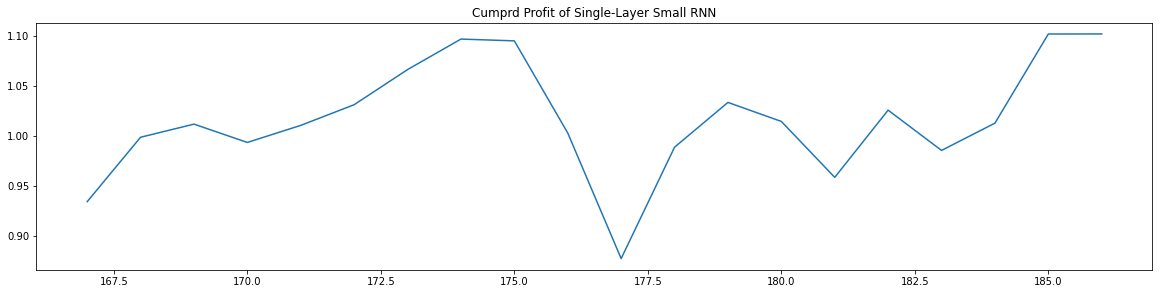

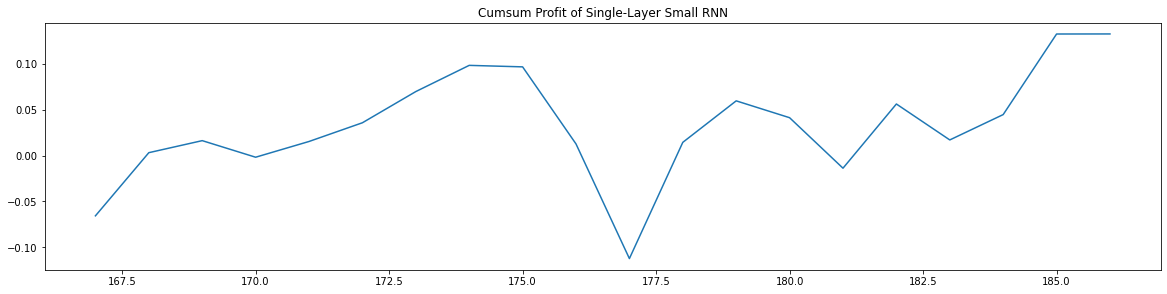

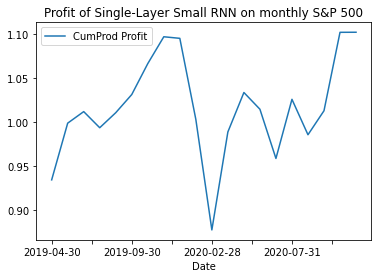

In [52]:
date = df.iloc[167:, :]['Date']
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=single_layer_small_rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of single layer small rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of single layer small rnn:', cumsprofit)
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Single-Layer Small RNN')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Single-Layer Small RNN')
plt.show()
profit_df = pd.DataFrame(columns=['Date', 'profit'])
profit_df['Date'] = date
profit_df['CumProd Profit'] = cumpprofit.values
profit_df.plot(x = 'Date', y = 'CumProd Profit', title = 'Profit of Single-Layer Small RNN on monthly S&P 500')
plt.show()

cumproduct profit of single layer rnn: 167    0.934222
168    0.998618
169    1.011728
170    0.993425
171    1.010493
172    1.031139
173    1.066246
174    1.096730
175    1.094944
176    1.002848
177    0.877372
178    0.988662
179    1.033430
180    1.052433
181    0.994443
182    1.064118
183    1.022375
184    0.994090
185    1.081517
186    1.081596
Name: short, dtype: float64
cumsum profit of single layer rnn: 167   -0.065778
168    0.003152
169    0.016281
170   -0.001811
171    0.015370
172    0.035802
173    0.069849
174    0.098439
175    0.096811
176    0.012700
177   -0.112419
178    0.014425
179    0.059707
180    0.078095
181    0.022994
182    0.093059
183    0.053831
184    0.026165
185    0.114111
186    0.114184
Name: short, dtype: float64


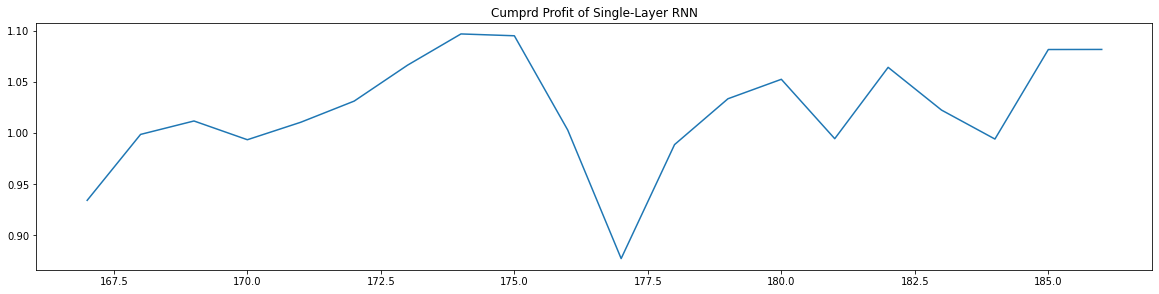

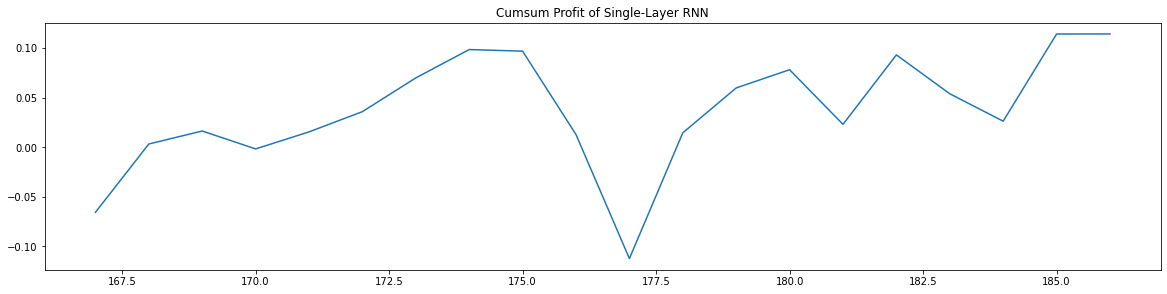

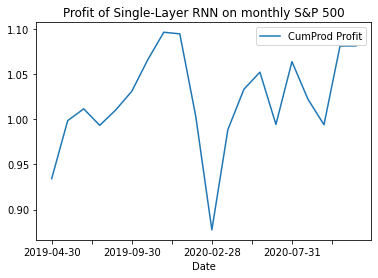

In [53]:
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=single_layer_rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of single layer rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of single layer rnn:', cumsprofit)

fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Single-Layer RNN')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Single-Layer RNN')
plt.show()
profit_df = pd.DataFrame(columns=['Date', 'profit'])
profit_df['Date'] = date
profit_df['CumProd Profit'] = cumpprofit.values
profit_df.plot(x = 'Date', y = 'CumProd Profit', title = 'Profit of Single-Layer RNN on monthly S&P 500')
plt.show()

cumproduct profit of multi layer rnn: 167    0.934222
168    0.869826
169    0.881245
170    0.865302
171    0.880169
172    0.898153
173    0.928732
174    0.955284
175    0.956840
176    0.876359
177    0.986009
178    1.111078
179    1.161390
180    1.182746
181    1.247917
182    1.160482
183    1.206005
184    1.172640
185    1.275769
186    1.275862
Name: short, dtype: float64
cumsum profit of multi layer rnn: 167   -0.065778
168   -0.134708
169   -0.121580
170   -0.139671
171   -0.122490
172   -0.102058
173   -0.068011
174   -0.039422
175   -0.037793
176   -0.121904
177    0.003215
178    0.130059
179    0.175341
180    0.193730
181    0.248831
182    0.178766
183    0.217994
184    0.190328
185    0.278274
186    0.278348
Name: short, dtype: float64


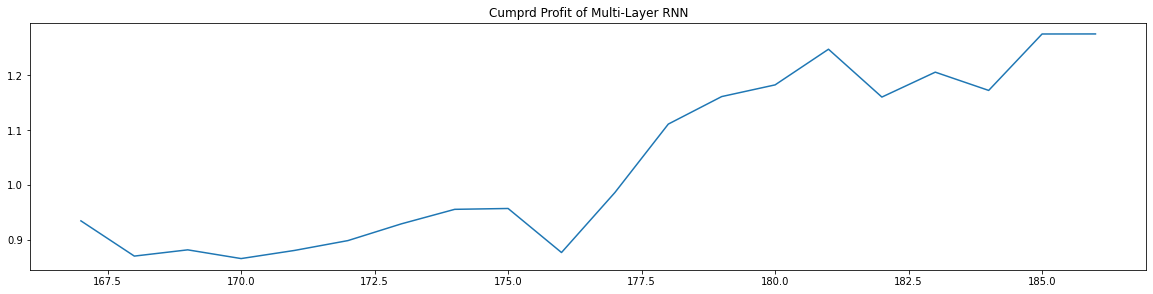

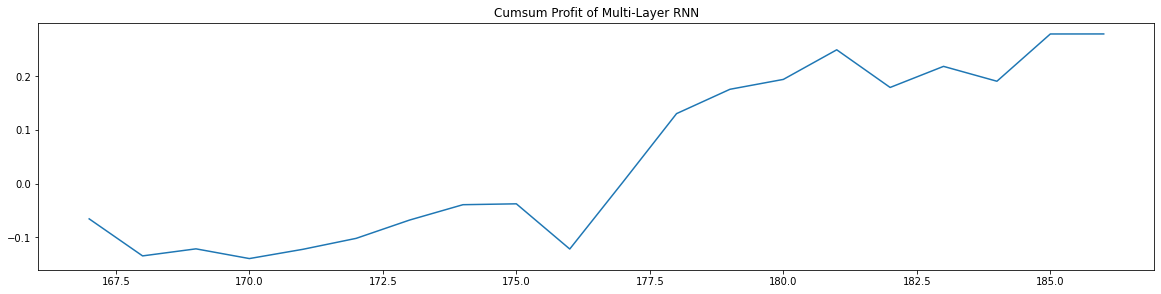

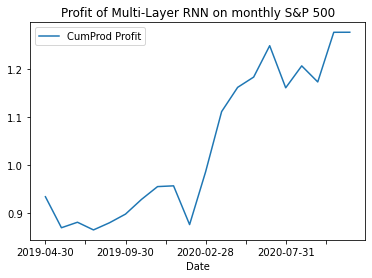

In [54]:
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of multi layer rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of multi layer rnn:', cumsprofit)

fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Multi-Layer RNN')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Multi-Layer RNN')
plt.show()
profit_df = pd.DataFrame(columns=['Date', 'profit'])
profit_df['Date'] = date
profit_df['CumProd Profit'] = cumpprofit.values
profit_df.plot(x = 'Date', y = 'CumProd Profit', title = 'Profit of Multi-Layer RNN on monthly S&P 500')
plt.show()

In [48]:
marketcump=(ret+1).cumprod()
marketcump

167    0.934222
168    0.998618
169    1.011728
170    0.993425
171    1.010493
172    1.031139
173    1.066246
174    1.096730
175    1.094944
176    1.002848
177    0.877372
178    0.988662
179    1.033430
180    1.052433
181    1.110424
182    1.188225
183    1.141614
184    1.110030
185    1.207653
186    1.207741
Name: return, dtype: float64

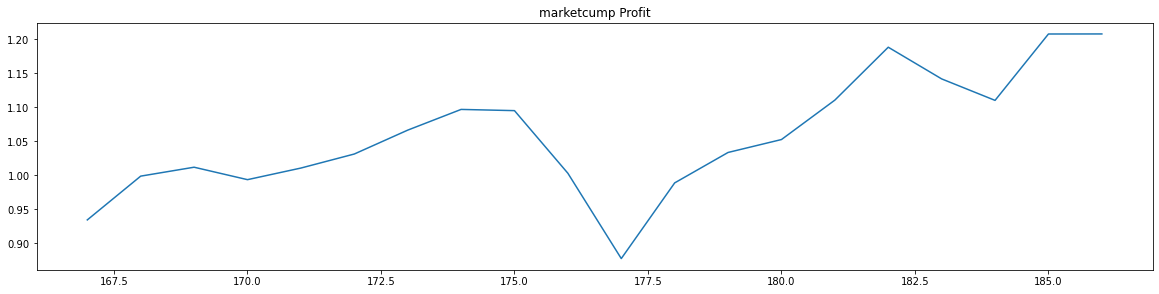

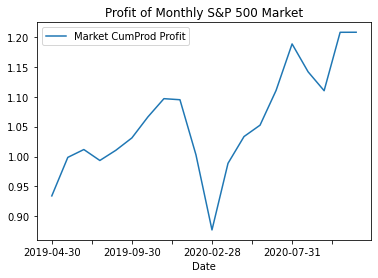

In [55]:
fig = plt.figure(figsize=(20,10))
ax3 = fig.add_subplot(2,1,1)
ax3.plot(marketcump)
ax3.set_title('marketcump Profit')
plt.show()
mkt_df = pd.DataFrame(columns=['Date', 'Market CumProd Profit'])
mkt_df['Date'] = date
profit_df['Market CumProd Profit'] = marketcump.values
profit_df.plot(x = 'Date', y = 'Market CumProd Profit', title = 'Profit of Monthly S&P 500 Market')
plt.show()

In [50]:
marketcums=ret.cumsum()
marketcums

167   -0.065778
168    0.003152
169    0.016281
170   -0.001811
171    0.015370
172    0.035802
173    0.069849
174    0.098439
175    0.096811
176    0.012700
177   -0.112419
178    0.014425
179    0.059707
180    0.078095
181    0.133196
182    0.203261
183    0.164033
184    0.136367
185    0.224313
186    0.224387
Name: return, dtype: float64

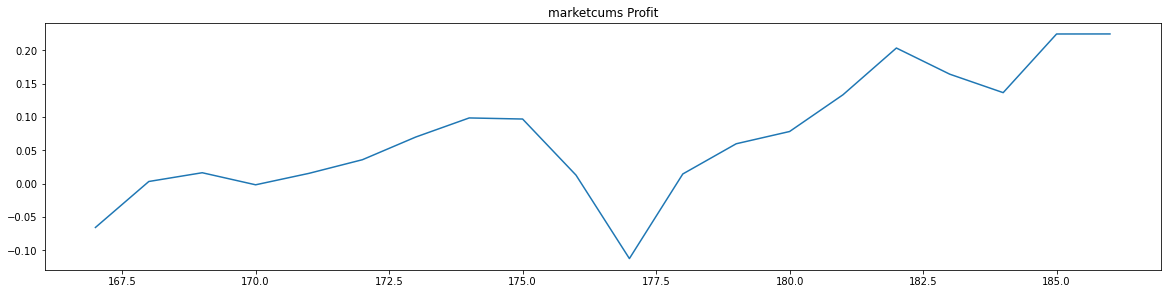

In [51]:
fig = plt.figure(figsize=(20,10))
ax2 = fig.add_subplot(2,1,1)
ax2.plot(marketcums)
ax2.set_title('marketcums Profit')
plt.show()